# CS543 Final Project CP1

04-14-2019

Yu Chen, Yu Chen, Yite Wang, Yuan Zhang

yuc5@illinois.edu; yuc6@illinois.edu; yitew2@illinois.edu; yuanz4@illinois.edu; 

## Include libraries

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.transform import Rotation as Rot
from scipy import spatial
import cv2
import re
import math
import matplotlib.pyplot as plt
import logging
logging.basicConfig(level=logging.INFO)

from mpl_toolkits.mplot3d import Axes3D

## Functions

In [6]:
def rotationMatrixToEulerAngles(R) :
    sy = math.sqrt(R[0,0] * R[0,0] +  R[1,0] * R[1,0])
    singular = sy < 1e-6
    if  not singular :
        x = math.atan2(R[2,1] , R[2,2])
        y = math.atan2(-R[2,0], sy)
        z = math.atan2(R[1,0], R[0,0])
    else :
        x = math.atan2(-R[1,2], R[1,1])
        y = math.atan2(-R[2,0], sy)
        z = 0
    return np.array([x, y, z])

def eulerAnglesToRotationMatrix(theta) :
    R_x = np.array([[1,         0,                  0                   ],
                    [0,         math.cos(theta[0]), -math.sin(theta[0]) ],
                    [0,         math.sin(theta[0]), math.cos(theta[0])  ]
                    ])
        
    R_y = np.array([[math.cos(theta[1]),    0,      math.sin(theta[1])  ],
                    [0,                     1,      0                   ],
                    [-math.sin(theta[1]),   0,      math.cos(theta[1])  ]
                    ])         
    R_z = np.array([[math.cos(theta[2]),    -math.sin(theta[2]),    0],
                    [math.sin(theta[2]),    math.cos(theta[2]),     0],
                    [0,                     0,                      1]
                    ])          
    R = np.dot(R_z, np.dot( R_y, R_x ))
    return R

def sharpening(img):
    imgb = cv2.GaussianBlur(img,(5,5), 2)    
    img = cv2.addWeighted(img, 2, imgb, -1, 0)
    return img

def centeroid(a):
    length = a.shape[0]
    x = np.sum(a[0,:])/length
    y = np.sum(a[1,:])/length
    z = np.sum(a[2,:])/length
    return x,y,z

def FLANN(dis_Threshold,kp1,kp2,des1,des2):
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 10)
    search_params = dict(checks=25)
    flann = cv2.FlannBasedMatcher(index_params,search_params)
    matches = flann.knnMatch(des1,des2,k=2)
    
    good = []
    pts1 = []
    pts2 = []
    desg1 = []

    for i,(m,n) in enumerate(matches):
        if m.distance < dis_Threshold*n.distance:
            good.append(m)
            pts1.append(kp1[m.queryIdx].pt)
            pts2.append(kp2[m.trainIdx].pt)
            desg1.append(des1[m.queryIdx])
            
    pts1_E = np.asarray(pts1)
    pts2_E = np.asarray(pts2)
    
    return pts1_E, pts2_E, desg1


def FLANN3d(kp1,kp2,des1,des2):
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params,search_params)
    matches = flann.knnMatch(np.asarray(des1,np.float32),np.asarray(des2,np.float32),k=2)
    
    good = []
    pts1 = []
    pts2 = []
    for i,(m,n) in enumerate(matches):
        if m.distance < 0.7*n.distance:
            good.append(m)
            pts1.append(kp1[m.queryIdx])
            pts2.append(kp2[m.trainIdx])
            
    pts1_E = np.asarray(pts1)
    pts2_E = np.asarray(pts2)
    
    return pts1_E, pts2_E

def match3d(pcd1,pcd2,de1,de2):
    dist = np.zeros([len(de1),len(de2)])
    dist = spatial.distance.cdist(de1,de2,'sqeuclidean')
    matchThreshold = 1.5*(np.amax(dist)-np.amin(dist))/100
    pre_match = np.where(dist < matchThreshold)
    #match = list(zip(pre_match[0], pre_match[1]))
    mc_1 = np.array([pcd1[:,i] for i in pre_match[0]]).reshape(-1, 3)
    mc_2 = np.array([pcd2[:,i] for i in pre_match[1]]).reshape(-1, 3)
    
    return mc_1,mc_2

def pcd3Dplot(pcd1,pcd2,cen1,cen2):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    x1 = pcd1[:,0]
    y1 = pcd1[:,1]
    z1 = pcd1[:,2]
    
    x2 = pcd2[:,0]
    y2 = pcd2[:,1]
    z2 = pcd2[:,2]
    
    cx1 = cen1[0]
    cy1 = cen1[1]
    cz1 = cen1[2]
    
    cx2 = cen2[0]
    cy2 = cen2[1]
    cz2 = cen2[2]
    
    ax.scatter3D(x1, y1, z1, c='r', marker='o')
    ax.scatter3D(cx1, cy1, cz1, c='b', marker='x')
    
    ax.scatter3D(x2, y2, z2, c='g', marker='o')
    ax.scatter3D(cx2, cy2, cz2, c='y', marker='x')
    
    ax.set_xlabel('x axis')
    ax.set_ylabel('y axis')
    ax.set_zlabel('z axis')
    
def trimPi(a):
    if a >= np.pi:
        a = a - 2*np.pi
    if a <= -np.pi:
        a = a + 2*np.pi
    return a

def solve(index,P0,P1,r_old1,r_old2):
    IMG_L_DIR = 'image_0/'
    IMG_R_DIR = 'image_1/'
    num1 = str(index)
    num2 = str(index+1)
    num1_0 = 6-len(num1)
    num2_0 = 6-len(num2)
    IMG_NAME_1 = '0'*num1_0 + num1 + '.png'
    IMG_NAME_2 = '0'*num2_0 + num2 + '.png'

    img_L_1 = cv2.imread(IMG_L_DIR + IMG_NAME_1)
    img_L_2 = cv2.imread(IMG_L_DIR + IMG_NAME_2)
    img_R_1 = cv2.imread(IMG_R_DIR + IMG_NAME_1)
    img_R_2 = cv2.imread(IMG_R_DIR + IMG_NAME_2)    
    
    sift = cv2.xfeatures2d.SIFT_create()
    kp_l1, des_l1 = sift.detectAndCompute(img_L_1,None)

    # Apply sharpening filter if feature count is low
    if len(kp_l1) <= 1700:
        img_L_1 = sharpening(img_L_1)
        img_L_2 = sharpening(img_L_2)
        img_R_1 = sharpening(img_R_1)
        img_R_2 = sharpening(img_R_2)
        kp_l1, des_l1 = sift.detectAndCompute(img_L_1,None)
        kp_l2, des_l2 = sift.detectAndCompute(img_L_2,None)
        kp_r1, des_r1 = sift.detectAndCompute(img_R_1,None)
        kp_r2, des_r2 = sift.detectAndCompute(img_R_2,None)
    else:
        kp_l2, des_l2 = sift.detectAndCompute(img_L_2,None)
        kp_r1, des_r1 = sift.detectAndCompute(img_R_1,None)
        kp_r2, des_r2 = sift.detectAndCompute(img_R_2,None)

    # Adaptive threshold for finding feasible FLANN matches
    dis_Threshold = 0.65+((1600-len(kp_l1))/6250)
    dis_Threshold = np.clip(dis_Threshold,0.6,0.7)
     
    pts_L_E1, pts_R_E1, desg_l1 = FLANN(dis_Threshold,kp_l1,kp_r1,des_l1,des_r1)
    pts_L_E2, pts_R_E2, desg_l2  = FLANN(dis_Threshold,kp_l2,kp_r2,des_l2,des_r2)
  
    frame1_3D = cv2.triangulatePoints(P0,P1,np.asarray(pts_L_E1.T,np.float32),np.asarray(pts_R_E1.T,np.float32))
    frame2_3D = cv2.triangulatePoints(P0,P1,np.asarray(pts_L_E2.T,np.float32),np.asarray(pts_R_E2.T,np.float32))
    
    frame1_3D = frame1_3D/frame1_3D[3,:]
    frame2_3D = frame2_3D/frame2_3D[3,:]
    frame1_3D = frame1_3D[:3,:]
    frame2_3D = frame2_3D[:3,:]
    
    pcd1,pcd2 = FLANN3d(frame1_3D.T,frame2_3D.T,desg_l1,desg_l2)
    
    cen1 = np.asarray(centeroid(pcd1))
    cen2 = np.asarray(centeroid(pcd2))

    pcd1 = pcd1 - cen1
    pcd2 = pcd2 - cen2
    
    pcd3Dplot(pcd1,pcd2,cen1,cen2)
    
    M = np.array([np.dot(pcd1[i,:].reshape(3,1),pcd2[i,:].reshape(1,3)) for i in range(len(pcd1))])
    M = np.sum(M,axis=0)

    U, s, V = np.linalg.svd(M)
    
    R = np.dot(V,U.T)
    S = np.zeros([3,3])
    np.fill_diagonal(S, (1,1,np.linalg.det(R)))
    
    R = np.dot(np.dot(V,S),U.T)
    t = (cen2.reshape(3,1) - np.dot(R,cen1.reshape(3,1))).reshape(3)

    # Egomotion adpative post-processing    
    t[0] = 0
    t[1] = 0
    
    Angle = rotationMatrixToEulerAngles(R)

    # Noise processing and trim 2pi
    Angle[0] = trimPi(Angle[0])
    Angle[1] = trimPi(Angle[1])
    Angle[2] = trimPi(Angle[2])
    Angle[abs(Angle)<= 0.0002] = 0
    Angle = np.clip(Angle, -6*(np.pi/180), 6*(np.pi/180))
    
    
    if pcd1.shape[0] <= 300:
        # Apply 3 moving average
        Ao1 = rotationMatrixToEulerAngles(r_old1)
        Ao2 = rotationMatrixToEulerAngles(r_old2)
        Angle = (Ao1 + Ao2 + 3*Angle) / 5
        
    elif pcd1.shape[0] <= 250:
        # Apply 3 moving average
        Ao1 = rotationMatrixToEulerAngles(r_old1)
        Ao2 = rotationMatrixToEulerAngles(r_old2)
        Angle = (Ao1 + Ao2 + 2*Angle) / 4

    R = eulerAnglesToRotationMatrix(Angle)
        

    return R, t

## Read camera parameters

In [3]:
# Find Intrinsic Parameters
CamP = np.loadtxt('KITTI  sample dataset/dataset/sequences/00/calib.txt','str')[:,1:].astype(np.float)
P0 = CamP[0,:].reshape((3,4))
P1 = CamP[1,:].reshape((3,4))

## Read from Ground Truth

In [4]:
ReadGT = np.loadtxt('KITTI  sample dataset/dataset/poses/00.txt')
Rs = np.reshape(ReadGT,(3*len(ReadGT),4))[:,:-1]
translation = np.reshape(np.reshape(ReadGT,(3*len(ReadGT),4))[:,-1:],(len(ReadGT),3))
rotation = np.zeros([len(ReadGT),3,3])
rotation[0:len(ReadGT),0,:] = Rs[::3,:]
rotation[0:len(ReadGT),1,:] = Rs[1::3,:]
rotation[0:len(ReadGT),2,:] = Rs[2::3,:]

## Main

<IPython.core.display.Javascript object>


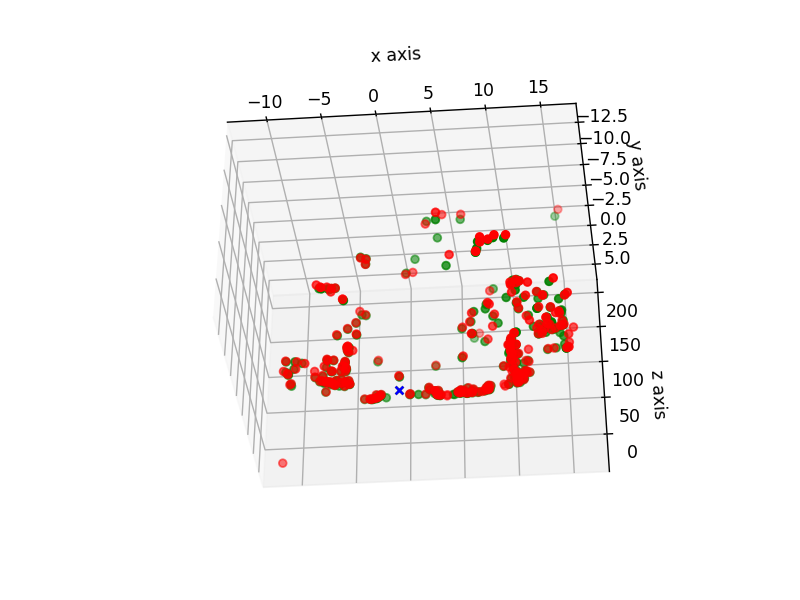

In [9]:
index = 850


r = np.zeros((3, 3))
r_old1 = np.zeros((3, 3))
r_old2 = np.zeros((3, 3))
t0 = np.zeros(3)

r, t0 = solve(index,P0,P1,r_old1,r_old2)


In [256]:
index0 = 0
index = 250
NEW_OPTICAL = True

N = 3
r = np.zeros((index, 3, 3))
r_old1 = np.zeros((3, 3))
r_old2 = np.zeros((3, 3))

t0 = np.zeros((index, 3))
t = np.zeros((index-(N-1), 3))

if NEW_OPTICAL is True:
    for i in range(index0,index):
        r[i], t0[i] = solve(i,P0,P1,r_old1,r_old2)
        if i >= N:
            r_old1 = r[i]
            r_old2 = r_old1

        if i % (index/100) == 0:
            logging.info(' '+str(100*i/index)+'%  Processed - ' + str(i))
        elif (i == index-1):
            print('--> 100% Done')
    
    # Apply 3 moving average on translation
    t[:,0] = np.convolve(t0[:,0], np.ones((N,))/N, mode='valid') 
    t[:,1] = np.convolve(t0[:,1], np.ones((N,))/N, mode='valid') 
    t[:,2] = np.convolve(t0[:,2], np.ones((N,))/N, mode='valid') 
    t = np.append(t,t0[(index-(N-1)):index,:], axis=0)

    np.save('0-249/r_0-249', r)
    np.save('0-249/t_0-249', t)
    
else:
    r = np.load('0-249/r_0-249.npy')
    t = np.load('0-249/t_0-249.npy')

INFO:root: 0.0%  Processed - 0
INFO:root: 2.0%  Processed - 5
INFO:root: 4.0%  Processed - 10
INFO:root: 6.0%  Processed - 15
INFO:root: 8.0%  Processed - 20
INFO:root: 10.0%  Processed - 25
INFO:root: 12.0%  Processed - 30
INFO:root: 14.0%  Processed - 35
INFO:root: 16.0%  Processed - 40
INFO:root: 18.0%  Processed - 45
INFO:root: 20.0%  Processed - 50
INFO:root: 22.0%  Processed - 55
INFO:root: 24.0%  Processed - 60
INFO:root: 26.0%  Processed - 65
INFO:root: 28.0%  Processed - 70
INFO:root: 30.0%  Processed - 75
INFO:root: 32.0%  Processed - 80
INFO:root: 34.0%  Processed - 85
INFO:root: 36.0%  Processed - 90
INFO:root: 38.0%  Processed - 95
INFO:root: 40.0%  Processed - 100
INFO:root: 42.0%  Processed - 105
INFO:root: 44.0%  Processed - 110
INFO:root: 46.0%  Processed - 115
INFO:root: 48.0%  Processed - 120
INFO:root: 50.0%  Processed - 125
INFO:root: 52.0%  Processed - 130
INFO:root: 54.0%  Processed - 135
INFO:root: 56.0%  Processed - 140
INFO:root: 58.0%  Processed - 145
INFO:ro

--> 100% Done


## Generate trajectory from results

In [257]:
T = np.zeros(3)
R = np.eye(3)
T_list = np.zeros((index, 3))
R_list = np.zeros((index, 3, 3))
for i in range(index0,index):
    T += R @ t[i]
    R = R @ r[i]
    T_list[i] = T
    R_list[i] = R

## Trajectory validation

<IPython.core.display.Javascript object>


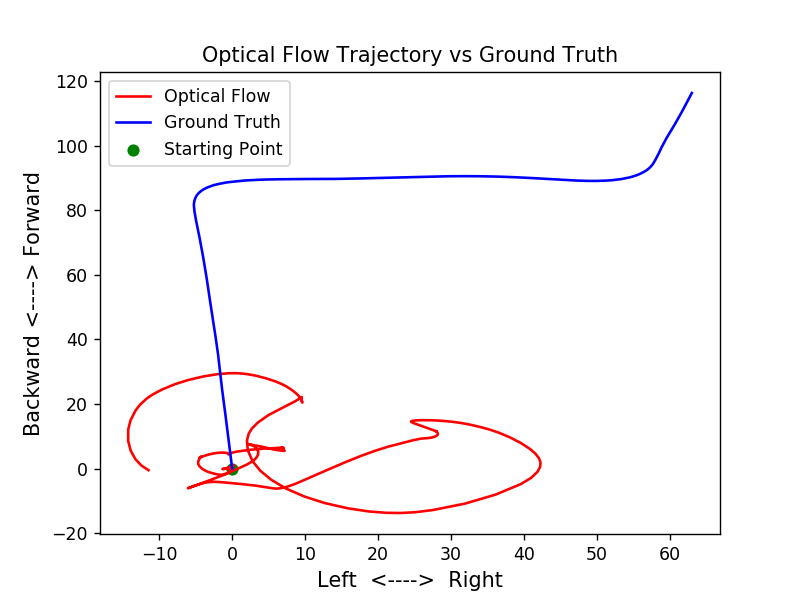

In [260]:
#scaling factor to remedy focal length unit conversion
Scaling1 = 100
Scaling2 = 100

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(T_list[0,0], -T_list[0,2], c='g')
ax.plot(Scaling1*T_list[:,0], -Scaling2*T_list[:,2],c='r')
ax.plot(translation[index0:index,0], translation[index0:index,2],c='b')
plt.legend(['Optical Flow','Ground Truth','Starting Point'])
plt.title('Optical Flow Trajectory vs Ground Truth')
plt.xlabel('Left  <---->  Right', fontsize='12')
plt.ylabel('Backward <----> Forward', fontsize='12')
plt.show()